In [2]:
from google.colab import drive 
drive.mount("/content/drive")
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PseudoCode and Task List

1. Load the pickled pandas dataframe from 04 notebook and check file contents
2. Prep the dataset for analysis
>2a. Factorize Tags column to a numeric column
>2b. Split into dev, cv, and test sets
>2c. Verify the distribution of tags within the splits
>2d. Create a separate dataframe for each of the predictor variables in the splits
3. Performing 1st of 3 different transformations: Count Vectorization and hypertune parameters
4. Performing 2nd of 3 different transformations: TF-IDF and hypertune parameters
5. Performing 3rd of 3 different transformations: Doc2Vec and hypertune parameters


# Tasks 1 Load file and examine contents

In [3]:
'''
1a Import all modules that are needed
'''
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import re
import nltk
import itertools
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prettytable import PrettyTable

In [4]:
'''
1b Load file 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24330 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              24330 non-null  int64 
 1   Tag             24330 non-null  object
 2   BodyText_Clean  24330 non-null  object
dtypes: int64(1), object(2)
memory usage: 760.3+ KB
'''

questions_df_clean = pd.read_pickle("/content/drive/My Drive/Capstone2/Data/questions_df_clean_11052020.pickle")
#questions_df_clean = pd.read_pickle('/content/drive/MyDrive/Data Science/Laura_CP2/Copy of questions_df_clean_11052020.pickle')
#questions_df_clean.info()

In [5]:
'''
1c. Examine contents
'''
questions_df_clean.head()
#questions_df_clean.loc[questions_df_clean['BodyText_Clean'].isnull()]
#questions_df_clean.loc[questions_df_clean['Tag'].isnull()]

,Id,Tag,BodyText_Clean
0,5,machine-learning,always interest machine learn figure one thing...
1,7,Other,researcher instructor look opensource book sim...
2,14,data-mining,sure data science discus forum several synonym...
3,15,Other,situation would one system prefer relative adv...
4,16,machine-learning,use libsvm train data predict classification s...


# Task 2 - Prep for modelling
>2a. Factorize Tags column to numeric column
>2b. Split into dev, cv, and test sets
>2c. Verify the distribution of tags within the splits

In [6]:
''' 
2a. Factorize Tags Column to numeric
Converting tag column (our target variable) to a numeric column for modelling; 
'''
questions_df_factorized = questions_df_clean.copy()
#Creating the dependent variable class
factor = pd.factorize(questions_df_factorized['Tag'])
questions_df_factorized.Tag = factor[0]
definitions = factor[1]
print(questions_df_factorized.head())
print(questions_df_clean.head())
print(definitions)
print(factor)

   Id  Tag                                     BodyText_Clean
0   5    0  always interest machine learn figure one thing...
1   7    1  researcher instructor look opensource book sim...
2  14    2  sure data science discus forum several synonym...
3  15    1  situation would one system prefer relative adv...
4  16    0  use libsvm train data predict classification s...
   Id               Tag                                     BodyText_Clean
0   5  machine-learning  always interest machine learn figure one thing...
1   7             Other  researcher instructor look opensource book sim...
2  14       data-mining  sure data science discus forum several synonym...
3  15             Other  situation would one system prefer relative adv...
4  16  machine-learning  use libsvm train data predict classification s...
Index(['machine-learning', 'Other', 'data-mining', 'bigdata', 'r',
       'statistics', 'clustering', 'recommender-system', 'nlp',
       'feature-selection', 'neural-network', '

In [7]:
'''
2b. Split into train (70%) / test (30%). Use the train data and further split into train/val split (similar ratio). 
Leaving the test split to the end.
Splitting into target (y) and predictor (X) variable sets and then into 
test and train sets and using stratification, given that the tag distribution is imbalanced
'''
# Splitting X and y variables
X=questions_df_factorized[list(questions_df_factorized.columns)[2]]
y=questions_df_factorized[list(questions_df_factorized.columns)[1]]
print(X.shape)
print(y.shape)
# Splitting into train, test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, stratify=y,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# Further splitting train into dev and validation
X_dev, X_cv, y_dev, y_cv = train_test_split(X_train,y_train,test_size = 0.30,stratify=y_train,random_state=42)
print(X_dev.shape, y_dev.shape)
print(X_cv.shape, y_cv.shape)


(24330,)
(24330,)
(17031,) (17031,)
(7299,) (7299,)
(11921,) (11921,)
(5110,) (5110,)


In [8]:
print(type(y_dev))
y_dev.isnull().sum()

<class 'pandas.core.series.Series'>


0

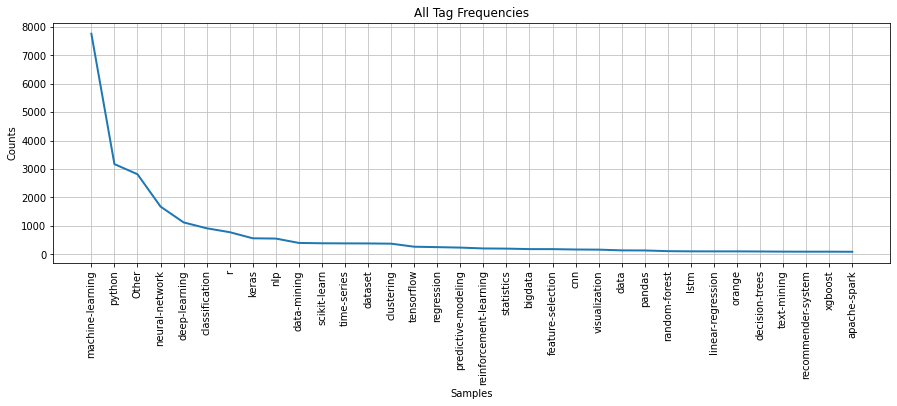

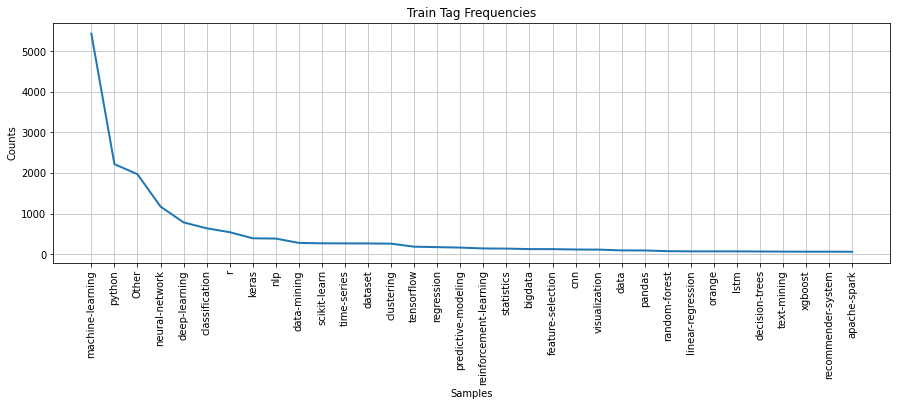

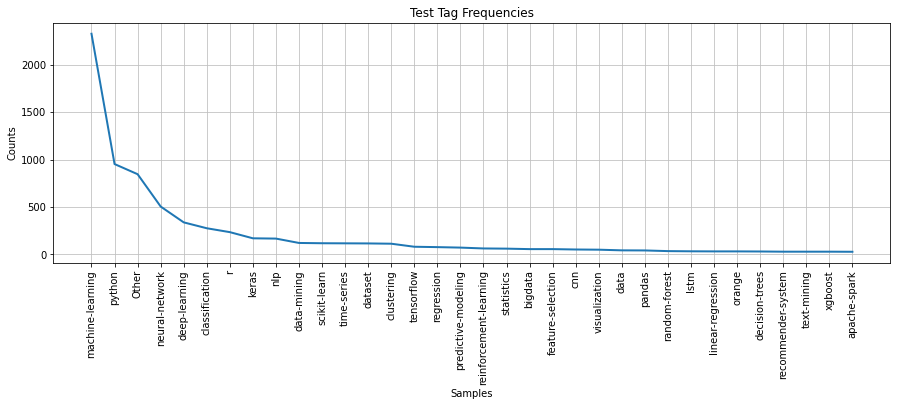

In [9]:
'''
2c. Verify the distribution of tags within the splits - is it consistent with the general population
In other words did the stratify process work?
'''
# First get lists of all tags in general dataframe, and in test and train splits
all_tags = questions_df_clean['Tag'].tolist()

reversefactor = dict(zip(range(34),definitions))
y_train_rf = np.vectorize(reversefactor.get)(y_train)

train_tags =  y_train_rf.tolist() 

y_test_rf = np.vectorize(reversefactor.get)(y_test)
test_tags = y_test_rf.tolist() 

# Then use nltk freq dist to get frequencies and plot
tags_all = nltk.FreqDist(all_tags)
tags_train = nltk.FreqDist(train_tags)
tags_test = nltk.FreqDist(test_tags)

# Adjust size

plt.figure(figsize=(15,15))
#plt.tight_layout(pad = 10)
ax1 = plt.subplot(3,1,1)

tags_all.plot(34, title= "All Tag Frequencies", cumulative=False)

plt.figure(figsize=(15,15))
plt.subplot(3,1,2, sharex=ax1)

tags_train.plot(34, title= "Train Tag Frequencies", cumulative=False)

plt.figure(figsize=(15,15))
plt.subplot(3,1,3, sharex=ax1)

tags_test.plot(34, title= "Test Tag Frequencies", cumulative=False)


In [10]:
#2d. Create a separate dataframe for each of the predictor variables in the splits
X_dev = pd.DataFrame(X_dev)
X_cv = pd.DataFrame(X_cv)
X_test = pd.DataFrame(X_test)
X_train = pd.DataFrame(X_train)
X_dev.head()

,BodyText_Clean
8286,seems like thing httpswwwsciencedirectcomscien...
23415,build 2hidden layer mlp use keras use scikit l...
23360,write fast rcnn run problem back propagation g...
1698,hear multilayer perceptron approximate functio...
24085,try correlation analysis dataset data cleanse ...


In [11]:
# Last cleaning step to remove sole numerics to improve prediction results

X_dev['BodyText_Clean'] = X_dev['BodyText_Clean'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))
X_cv['BodyText_Clean'] = X_cv['BodyText_Clean'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))
X_test['BodyText_Clean'] = X_test['BodyText_Clean'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))
X_train['BodyText_Clean'] = X_train['BodyText_Clean'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))

# Task 3 - Performing 1st of 3 different transformations to convert the text data into numerical vector format; count vectorization
(using entire data set since we prefer to have a sample data set of 20K and total data set is 24K)
> 3a. Perform the actual count vectorization using default params and experimenting with param changes
> 3b. Build a base random forest model and perform hyperparameter tuning for count vectorization process - 
> 3c. Update visuals with results of hypertuning

In [ ]:
'''
3a. Count Vectorization transformation to convert text into a matrix of token counts
for now running with default min and max df values; results of train set is 42953 words in dictionary; result of dev set is 46514 unique words
'''
vect = CountVectorizer(tokenizer=lambda x: x.split(' '))
# learn data vocabulary, then use it to create a document-term matrix, convert to dense vector and write to dataframe
X_train_dtm_df = pd.DataFrame(vect.fit_transform(X_train.BodyText_Clean).toarray(), index=X_train.index, columns=vect.get_feature_names())
#print the total number of words vectorized and the unique words
print("Dic Size:", len(vect.get_feature_names()))
print("Dictionary:", vect.get_feature_names())
X_train_dtm_df.head()

Dic Size: 42953
Dictionary: ['', '0', '00', '000', '00000', '00000001', '0000000e00', '0000005', '00000e00', '00010000', '00011', '000117336', '000126', '0001v', '0002v', '000302', '0003n', '0004', '0005001times', '0005099times', '000601132', '000812', '000overline90', '000x', '001', '001602', '001batchsize', '001decay', '001i', '001t', '002', '002597', '0026x23', '003', '00312severe', '003712', '003grams', '0041controversial', '0041key', '0041minister', '0041moments', '0041prime', '0041tfidfprime', '0044715x3', '004854', '005661938', '005924', '005age', '005n', '005x3', '006193804', '006345133', '0068288', '007', '00x1', '00x2', '00x3', '01', '010t', '011', '012', '0123', '013592493', '01409medium', '014903974', '014973508', '015m', '016141416', '0167', '016so', '017', '018', '019age', '01c', '01d', '01jan2009', '01m', '01n', '01rh', '01s', '01star', '01times', '01x3', '01x4', '02', '02034', '02040etc', '021', '021153846', '022', '024154082', '024333884', '025', '025outcomen2', '025te

,,0,00,000,00000,00000001,0000000e00,0000005,00000e00,00010000,00011,000117336,000126,0001v,0002v,000302,0003n,0004,0005001times,0005099times,000601132,000812,000overline90,000x,001,001602,001batchsize,001decay,001i,001t,002,002597,0026x23,003,00312severe,003712,003grams,0041controversial,0041key,0041minister,...,zn,znorm,znormalising,znormalization,znormalize,zof,zomato,zone,zoo,zoom,zoomablefit,zooming,zoos,zooz,zork,zoubin,zpartial,zplane,zpoints,zprediction,zr3,zrdid,zscore,zscoremean,zscores,zscoring,zsk1,zt,ztest,ztestthe,ztk,zu,zvalue,zwnew,zwold,zwoldw,zx,zz,zzz123yzzzzz,zzzzzzzzzzzzzzzzzgmailcom
21784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
'''
3a. Contd. Experiment with differences in min dif to see what effect it has
min_df is used for removing terms that appear too infrequently. For example:
min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the 
default setting does not ignore any terms.
Using .01 and .02 is pretty heavy handed - .01 is better because it is removing a lot of mispellings, hyperlinks, merged words 
but leaves us with only abou 800 words in the dictionary
0.01 Dic Size: 796 Words Removed: 45761
Also trying with a whole number (10 / 50) to reduce the number of excluded words; this works much better 
and is a bit more controllable and less heavy handed
50 Dic Size: 1774 Words Removed: 44783
10 Dic Size: 4442 Words Removed: 42115
'''
vect2 = CountVectorizer(min_df=10,tokenizer=lambda x: x.split(' '))
# learn data vocabulary, then use it to create a document-term matrix, convert to dense vector and write to dataframe
X2_train_dtm_df = pd.DataFrame(vect2.fit_transform(X_train.BodyText_Clean).toarray(), index=X_train.index, columns=vect2.get_feature_names())
#X2_train_dtm = vect2.fit_transform(X_train)
print("Dic Size:", len(vect2.get_feature_names()))
print("Words Removed:", len(vect2.stop_words_))
#Get a list of all words excluded in the process
print('Stop Words (removed): ')
vect2.stop_words_
#Get a list of all words kept in the process
#print('Vocabulary: ')
#vect2.vocabulary_

Dic Size: 4254
Words Removed: 38699
Stop Words (removed): 


{'determ',
 'thoghts',
 'glut',
 'pseudoinverse',
 'environmentwide',
 'lossfrac1n1cdotsumn0n',
 'saleswith',
 '5e3',
 'pxyoudfracalphaxyoumxyoualphaumyou',
 'parameter1',
 'framerate',
 'kerascontrib',
 'averageincluding',
 'cos',
 'saled',
 'friedmann',
 'fprs',
 'rfm',
 'bayesiangmm',
 'armax1',
 'sumk1kmklnmuk',
 'scalelength',
 'fracba',
 'ablue',
 'manifolds',
 'k52',
 '93ef5eb4',
 'lowrank',
 'tradition',
 'tensorflowdatasets',
 'specifyimply',
 'brains',
 't2t6t7',
 '04',
 'k8',
 'errors',
 'turi',
 'maching',
 'encodersi',
 'financebanking',
 '11',
 'fracdynidw2',
 'churners',
 'typei',
 'caluclated',
 'bananas',
 'sumjhajwkj',
 'leftdright',
 'textmatch',
 'squarederror',
 'softmaxal',
 'pa1b2c2c2',
 'qt1',
 'closeish',
 'dklqphizxptheta1z',
 'yolo3',
 'darts',
 'lightweight',
 'bertlargecased',
 '10w12',
 'softmazing',
 'geodata',
 'influx',
 'multiplesequenceinput',
 'sleeve',
 'canadas',
 'crisply',
 'buildtbranch',
 'alphaprodi1n',
 'sigmax',
 'taun',
 'textcovariance',
 

In [ ]:
'''
3a Contd. Experimenting with differences in max df to see what effect it has
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". 
Thus, the default setting does not ignore any terms.
Starting with .99 and .90 and .80 - nothing is removed
Dic Size: 46557 Words Removed: 0
Also trying with a whole number (10 / 50) to reduce the number of excluded words; this works much better 
and is a bit more controllable and less heavy handed
50 Dic Size: 44802 Words Removed: 1755
10 Dic Size: 42371 Words Removed: 4186
'''
vect3 = CountVectorizer(max_df=10, tokenizer=lambda x: x.split(' '))
# learn data vocabulary, then use it to create a document-term matrix, convert to dense vector and write to dataframe
X3_train_dtm_df = pd.DataFrame(vect3.fit_transform(X_train.BodyText_Clean).toarray(), index=X_train.index, columns=vect3.get_feature_names())
#X3_train_dtm = vect3.fit_transform(X_train)
print("Dic Size:", len(vect3.get_feature_names()))
print("Words Removed:", len(vect3.stop_words_))
#Get a list of all words excluded in the process
print('Stop Words (removed): ')
vect3.stop_words_
#Get a list of all words kept in the process
#print('Vocabulary: ')
#vect3.vocabulary_

Dic Size: 38941
Words Removed: 4012
Stop Words (removed): 


{'expect',
 '',
 'tradeoff',
 'penalty',
 'subsequently',
 'battery',
 'behave',
 'jaccard',
 'xs',
 'rather',
 'append',
 'medical',
 'exchange',
 'reduction',
 'confident',
 'functionality',
 'prune',
 '8',
 'atari',
 'independently',
 'direct',
 'repeat',
 'assist',
 'debug',
 'nabla',
 'lexicon',
 'masters',
 'voc',
 'bring',
 'intensive',
 'imagedatagenerator',
 'ip',
 'rise',
 'gender',
 'observation',
 '0',
 'distribution',
 'allow',
 'contain',
 'facebook',
 'interactive',
 'hyper',
 'tensorflow',
 'critic',
 'trim',
 'shuffle',
 'enhance',
 'precise',
 'descriptor',
 'dumb',
 'flight',
 'f1score',
 'social',
 'summation',
 '1x1',
 'ridge',
 'merge',
 'q',
 'probabilistic',
 'sql',
 'r2',
 'default',
 'date',
 'tesseract',
 'silly',
 'build',
 'man',
 'etc',
 'copy',
 'caffe',
 'invoice',
 'toolkit',
 'huge',
 '1dimensional',
 'prediction',
 'continous',
 'backward',
 'diabetes',
 'k',
 'unexpected',
 'imbalanced',
 'late',
 'search',
 'pc',
 'theano',
 'onehotencoded',
 'negat

In [ ]:
'''
3a Contd. Experimenting with setting both max and min values; just using the  max_df param removes the number of words used from 60K to 777
does not seem to matter whether I use .99 or .80 - same results of 777
using 0.01 / .99 for now
adjusting this to whole numbers for more control and for less heavy handedness
using min_df of 10 with any kind of max df results in 5317 words remaining
using min_df of 5 with any kind of max df results in 8098 words remaining

On final loop, using params returned from hyper param tuning - below
Dic Size: 14695
Words Removed: 1427010
'''
vect4 = CountVectorizer(min_df=10,max_df=1000, ngram_range=(1, 3))
# learn data vocabulary, then use it to create a document-term matrix, convert to dense vector and write to dataframe
X4_train_dtm_df = pd.DataFrame(vect4.fit_transform(X_train.BodyText_Clean).toarray(), index=X_train.index, columns=vect4.get_feature_names())
#X4_train_dtm = vect4.fit_transform(X_train)
print("Dic Size:", len(vect4.get_feature_names()))
print("Words Removed:", len(vect4.stop_words_))
#Get a list of all words excluded in the process - removing a lot of mispellings, hyperlinks, merged words
#vect4.stop_words_
#Get a list of all words kept in the process
#vect4.vocabulary_
#CV4_train_df = pd.DataFrame(X4_train_dtm.toarray(), columns=vect4.get_feature_names())
X4_train_dtm_df.head()
#feature_names = vect4.get_feature_names()
#dense4 = X4_dtm.todense()
#dense4list = dense4.tolist()
#CV_df = pd.DataFrame(dense4list, columns=feature_names)

Dic Size: 14566
Words Removed: 1379652


,10,100k,10fold,10fold cross,10fold cross validation,10k,12,150k,15k,16gb,16gb ram,1d,1d array,1dimensional,1k,1m,1n,1st,1x1,1x1 convolution,200k,20k,224x224,256x256,28x28,2d,2d array,2d data,2d image,2d input,2dimensional,2k,2n,2nd,2x,2x2,300k,30k,32x32,3d,...,year want,year would,year year,yearly,yellow,yes,yes would,yesno,yesterday,yet,yet find,yet know,yi,yield,yield good,yn,yolo,yolov3,york,younet,young,youtube,ypred,yt,yt1,ytest,ytrain,ytrue,yx,zero,zero mean,zero one,zero pad,zero value,zeropadding,zip,zip code,zone,zoom,zscore
21784,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
'''
3b. Building a random forest multi-classification base model to evaluate the optimal params (min and max dfs and n-grams) for count vectorization

on final iteration - using the results from hyperparam tuning

vect4 = CountVectorizer(min_df=10,max_df=1000, ngram_range=(1, 3)) (11921, 9931) Train AUC Score: 1.0 Cross Val AUC Score: 0.8349
vect4 = CountVectorizer(min_df=10,max_df=1000, ngram_range=(1, 1)) (11921, 3403) Train AUC Score: 1.0 Cross Val AUC Score: 0.8444
vect = CountVectorizer(min_df=.005,max_df=.999, ngram_range=(1, 2)) (11921, 1563) Train AUC Score: 1.0 Cross Val AUC Score: 0.8622
vect = CountVectorizer(min_df=.001,max_df=.999, ngram_range=(1, 1)) (11921, 3144) Train AUC Score: 1.0 Cross Val AUC Score: 0.8627
vect = CountVectorizer(min_df=.005,max_df=.999, ngram_range=(1, 1)) (11921, 1231) Train AUC Score: 1.0 Cross Val AUC Score: 0.8627 
vect = CountVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 1)) (11921, 1231) Train AUC Score: 1.0 Cross Val AUC Score: 0.8627 <-----
vect = CountVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 2)) (11921, 1563) Train AUC Score: 1.0 Cross Val AUC Score: 0.8622
vect = CountVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 3)) (11921, 1580) Train AUC Score: 1.0 Cross Val AUC Score: 0.8614
vect = CountVectorizer(min_df=.01,max_df=.90, ngram_range=(1, 1)) (11921, 752) Train AUC Score: 1.0 Cross Val AUC Score: 0.8444
vect = CountVectorizer(min_df=.01,max_df=.80, ngram_range=(1, 1)) (11921, 752) Train AUC Score: 1.0 Cross Val AUC Score: 0.8444
vect = CountVectorizer(min_df=.01,max_df=.50, ngram_range=(1, 1)) (11921, 751) Train AUC Score: 1.0 Cross Val AUC Score: 0.8446
vect = CountVectorizer(min_df=.01,max_df=.50, ngram_range=(1, 3)) (11921, 846) Train AUC Score: 1.0 Cross Val AUC Score: 0.8407
'''
vect = CountVectorizer(min_df=.005,max_df=.999, ngram_range=(1, 2))
X_dev_dtm_df = pd.DataFrame(vect.fit_transform(X_dev.BodyText_Clean).toarray(), index=X_dev.index, columns=vect.get_feature_names())
print(X_dev_dtm_df.shape)
X_dev_dtm_df.head()
X_cv_dtm = vect.transform(X_cv.BodyText_Clean)

rf_base_cv  = RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy', random_state = 42)
rf_base_cv.fit(X_dev_dtm_df,y_dev)

(11921, 1563)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [16]:
'''
3b Print scores - AUC score for entire population is .6529; high train score - overfitting
'''
#print("Train Score:        ", round(rf_base_cv.score(X4_dev_dtm_df,y_dev),4))

y_dev_prob_cv = rf_base_cv.predict_proba(X_dev_dtm_df)
macro_roc_auc_ovo_dev_cv = roc_auc_score(y_dev, y_dev_prob_cv, multi_class="ovo",
                                  average="macro")
print("Train AUC Score:", round(macro_roc_auc_ovo_dev_cv,4))

y_cv_prob_cv = rf_base_cv.predict_proba(X_cv_dtm)
macro_roc_auc_ovo_cv = roc_auc_score(y_cv, y_cv_prob_cv, multi_class="ovo",
                                  average="macro")
print("Cross Val AUC Score:", round(macro_roc_auc_ovo_cv,4))

Train AUC Score: 1.0
Cross Val AUC Score: 0.8622


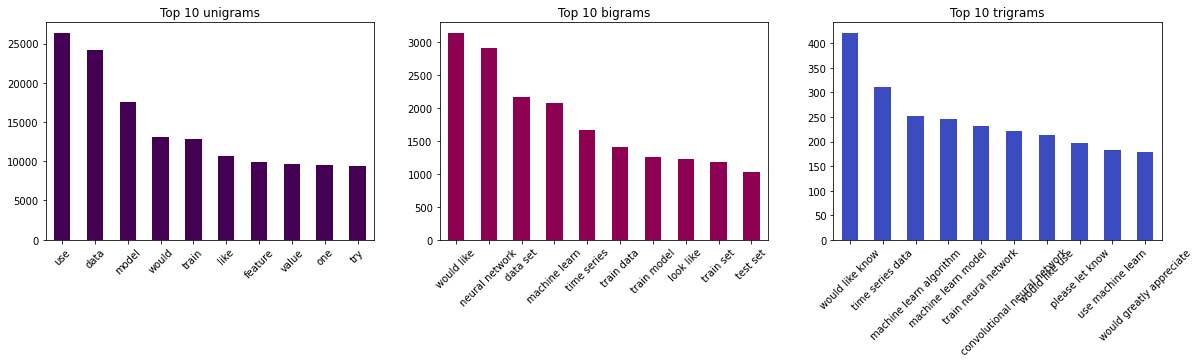

In [17]:
'''
3c. Visualizations the count vectorization results using the optimal count vectorizing params 
'''
def get_top_n_words(corpus, n, ngram):
    vect4 = CountVectorizer(min_df=.005,max_df=.99, ngram_range=(ngram, ngram)).fit(corpus) 
    bag_of_words = vect4.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect4.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Accepts series, top n key words, n_gram
unigrams = get_top_n_words(questions_df_clean['BodyText_Clean'], 10, 1)
bigrams = get_top_n_words(questions_df_clean['BodyText_Clean'], 10, 2)
trigrams = get_top_n_words(questions_df_clean['BodyText_Clean'], 10, 3)

def unpack(tuples):
    x_labels = [val[0] for val in tuples]
    y_labels = [val[1] for val in tuples]
    return x_labels, y_labels

# Adjust size
plt.figure(figsize=(20,4))

# Unigrams
ax_one = plt.subplot(1,3,1)
x_labels, y_labels = unpack(unigrams) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis', ax=ax_one) # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
ax.tick_params(axis='x', labelrotation = 45)
ax_one.set_title('Top 10 unigrams');

# Bigrams
ax_two = plt.subplot(1,3,2)
x_labels, y_labels = unpack(bigrams)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG', ax=ax_two)
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)
ax_two.set_title('Top 10 bigrams');

# Trigrams
ax_three = plt.subplot(1,3,3)
x_labels, y_labels = unpack(trigrams)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm', ax=ax_three)
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)
ax_three.set_title('Top 10 trigrams');

In [18]:
'''
3d. Continued - Revise the visualizations from above using the optimal count vectorizing params re-iterate on this step with 
dataframe filtered down to certain top 6 tags (machine-learning, python, neural-network, 
deep-learning, classification, and r - also visualization, since I noted
unique words associated with that topic)
'''
ML_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'machine-learning']
python_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'python']
NN_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'neural-network']
DL_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'deep-learning']
class_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'classification']  
r_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'r'] 
viz_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'visualization']                                 

# Accepts series, top n key words, n_gram
unigrams_ML = get_top_n_words(ML_df['BodyText_Clean'], 10, 1)
bigrams_ML = get_top_n_words(ML_df['BodyText_Clean'], 10, 2)
trigrams_ML = get_top_n_words(ML_df['BodyText_Clean'], 10, 3)

unigrams_python = get_top_n_words(python_df['BodyText_Clean'], 10, 1)
bigrams_python = get_top_n_words(python_df['BodyText_Clean'], 10, 2)
trigrams_python = get_top_n_words(python_df['BodyText_Clean'], 10, 3)

unigrams_NN = get_top_n_words(NN_df['BodyText_Clean'], 10, 1)
bigrams_NN = get_top_n_words(NN_df['BodyText_Clean'], 10, 2)
trigrams_NN = get_top_n_words(NN_df['BodyText_Clean'], 10, 3)

unigrams_DL = get_top_n_words(DL_df['BodyText_Clean'], 10, 1)
bigrams_DL = get_top_n_words(DL_df['BodyText_Clean'], 10, 2)
trigrams_DL = get_top_n_words(DL_df['BodyText_Clean'], 10, 3)

unigrams_class = get_top_n_words(class_df['BodyText_Clean'], 10, 1)
bigrams_class = get_top_n_words(class_df['BodyText_Clean'], 10, 2)
trigrams_class = get_top_n_words(class_df['BodyText_Clean'], 5, 3)

unigrams_r = get_top_n_words(r_df['BodyText_Clean'], 10, 1)
bigrams_r = get_top_n_words(r_df['BodyText_Clean'], 10, 2)
trigrams_r = get_top_n_words(r_df['BodyText_Clean'], 5, 3)

unigrams_viz = get_top_n_words(viz_df['BodyText_Clean'], 10, 1)
bigrams_viz = get_top_n_words(viz_df['BodyText_Clean'], 5, 2)
bigrams_viz = get_top_n_words(viz_df['BodyText_Clean'], 5, 2)

NameError: ignored

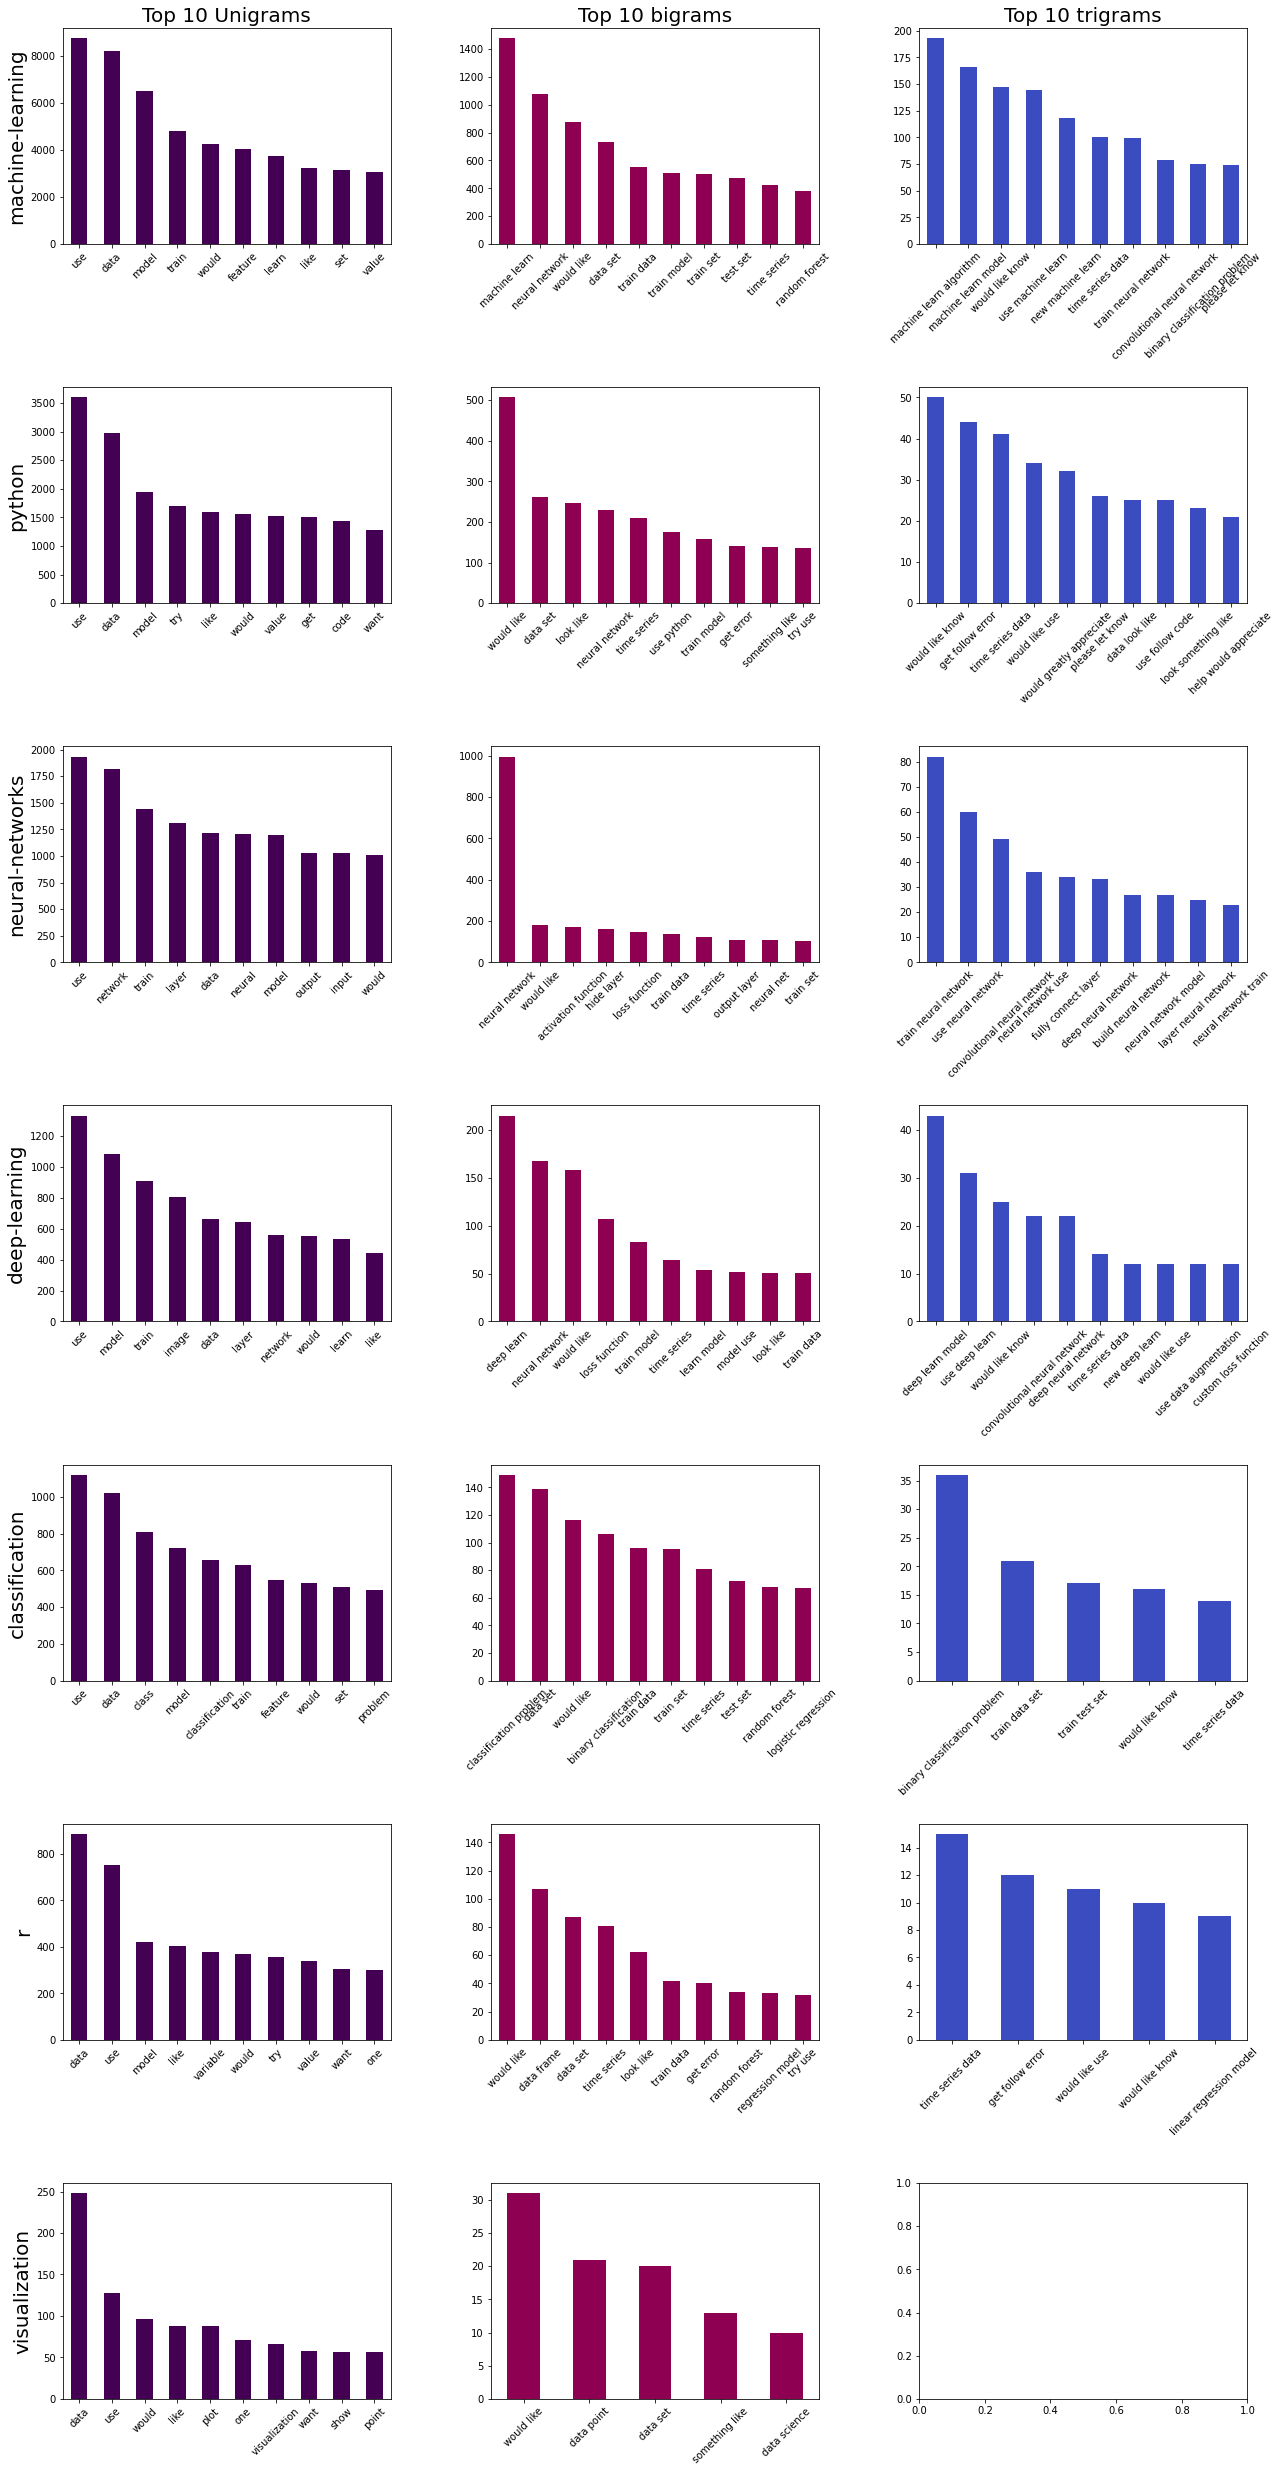

In [19]:
'''
3d Continued, Print results as subplots
'''
# Adjust size

#fig, axs = plt.subplots(4, 3)
plt.figure(figsize=(20,36))
plt.tight_layout(pad = 10)

# Unigrams
plt.subplot(7,3,1)
x_labels, y_labels = unpack(unigrams_ML) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
ax.set_title('Top 10 Unigrams', fontsize=20)
plt.ylabel('machine-learning', fontsize=20)
plt.tight_layout(pad = 10)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,4)
x_labels, y_labels = unpack(unigrams_python) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('python', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,7)
x_labels, y_labels = unpack(unigrams_NN) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('neural-networks', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,10)
x_labels, y_labels = unpack(unigrams_DL) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('deep-learning', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,13)
x_labels, y_labels = unpack(unigrams_class) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('classification', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,16)
x_labels, y_labels = unpack(unigrams_r) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('r', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,19)
x_labels, y_labels = unpack(unigrams_viz) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
plt.ylabel('visualization', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

# Bigrams
plt.subplot(7,3,2)
x_labels, y_labels = unpack(bigrams_ML)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.set_title('Top 10 bigrams', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,5)
x_labels, y_labels = unpack(bigrams_python)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,8)
x_labels, y_labels = unpack(bigrams_NN)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,11)
x_labels, y_labels = unpack(bigrams_DL)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,14)
x_labels, y_labels = unpack(bigrams_class)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,17)
x_labels, y_labels = unpack(bigrams_r)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,20)
x_labels, y_labels = unpack(bigrams_viz)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

# Trigrams
plt.subplot(7,3,3)
x_labels, y_labels = unpack(trigrams_ML)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.set_title('Top 10 trigrams', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,6)
x_labels, y_labels = unpack(trigrams_python)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,9)
x_labels, y_labels = unpack(trigrams_NN)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,12)
x_labels, y_labels = unpack(trigrams_DL)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,15)
x_labels, y_labels = unpack(trigrams_class)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,18)
x_labels, y_labels = unpack(trigrams_r)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,21)
x_labels, y_labels = unpack(trigrams_viz)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_labels)
ax.tick_params(axis='x', labelrotation = 45)


# Task 4 Using 3 different transformations to convert the text data into numerical vector format;TF-IDF - 2nd type of transformation
> 4a. Visualize distribution of unigram, bigram, and 
trigrams using the entire dataframe and by tag using tf-idf 
> 4b. Perform the actual tfidf transform using default params and experimenting with param changes
> 4c. Performing hyperparameter tuning for tf-idf process - using grid search CV
> 4d. Update visuals with hypertuned results

In [ ]:
'''
4a. Tfidf for 2nd model using unigrams, bigrams, and trigrams; this model will return probabilities 
for the tag; for now running with default param values; result of training set is 42924
'''
tfidf_vect = TfidfVectorizer()
tfidf_train_X = tfidf_vect.fit_transform(X_train.BodyText_Clean)

#print the total number of words vectorized and the unique words
print("Dic Size:", len(tfidf_vect.get_feature_names()))
print("Words Removed:", len(tfidf_vect.stop_words_))
print(tfidf_vect.get_feature_names())
# Convert dtm from sparse to dense vector and create df to review
TFIDF_train_df = pd.DataFrame(tfidf_train_X.toarray(), columns=tfidf_vect.get_feature_names())
TFIDF_train_df.head()

Dic Size: 42924
Words Removed: 0
['00', '000', '00000', '00000001', '0000000e00', '0000005', '00000e00', '00010000', '00011', '000117336', '000126', '0001v', '0002v', '000302', '0003n', '0004', '0005001times', '0005099times', '000601132', '000812', '000overline90', '000x', '001', '001602', '001batchsize', '001decay', '001i', '001t', '002', '002597', '0026x23', '003', '00312severe', '003712', '003grams', '0041controversial', '0041key', '0041minister', '0041moments', '0041prime', '0041tfidfprime', '0044715x3', '004854', '005661938', '005924', '005age', '005n', '005x3', '006193804', '006345133', '0068288', '007', '00x1', '00x2', '00x3', '01', '010t', '011', '012', '0123', '013592493', '01409medium', '014903974', '014973508', '015m', '016141416', '0167', '016so', '017', '018', '019age', '01c', '01d', '01jan2009', '01m', '01n', '01rh', '01s', '01star', '01times', '01x3', '01x4', '02', '02034', '02040etc', '021', '021153846', '022', '024154082', '024333884', '025', '025outcomen2', '025textxd

,00,000,00000,00000001,0000000e00,0000005,00000e00,00010000,00011,000117336,000126,0001v,0002v,000302,0003n,0004,0005001times,0005099times,000601132,000812,000overline90,000x,001,001602,001batchsize,001decay,001i,001t,002,002597,0026x23,003,00312severe,003712,003grams,0041controversial,0041key,0041minister,0041moments,0041prime,...,zn,znorm,znormalising,znormalization,znormalize,zof,zomato,zone,zoo,zoom,zoomablefit,zooming,zoos,zooz,zork,zoubin,zpartial,zplane,zpoints,zprediction,zr3,zrdid,zscore,zscoremean,zscores,zscoring,zsk1,zt,ztest,ztestthe,ztk,zu,zvalue,zwnew,zwold,zwoldw,zx,zz,zzz123yzzzzz,zzzzzzzzzzzzzzzzzgmailcom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'''
4a. Experiment with differences in min dif to see what effect it has
min_df is used for removing terms that appear too infrequently. Default used above = 1.0
For example:
min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the 
default setting does not ignore any terms.
Using .01 and .02 is pretty heavy handed - .01 is better because it is removing a lot of mispellings, hyperlinks, merged words 
but leaves us with only abou 768 words in the dictionary
0.01 Dic Size: 796 Words Removed: 45761
very similiar results to count vectorizer
Also trying with a whole number (10 / 50) to reduce the number of excluded words; this works much better 
and is a bit more controllable and less heavy handed
50 Dic Size: 1740 Words Removed: 44746
10 Dic Size: 4440 Words Removed: 42046
'''
tfidf_vect2 = TfidfVectorizer(min_df=50)
tfidf_train_X2 = tfidf_vect2.fit_transform(X_train.BodyText_Clean)

#print the total number of words vectorized and the unique words
print("Dic Size:", len(tfidf_vect2.get_feature_names()))
print("Words Removed:", len(tfidf_vect2.stop_words_))
print(tfidf_vect2.get_feature_names())

# Convert dtm from sparse to dense vector and create df to review
TFIDF_train_df2 = pd.DataFrame(tfidf_train_X2.toarray(), columns=tfidf_vect2.get_feature_names())
TFIDF_train_df2.head()


Dic Size: 1684
Words Removed: 41240
['100k', '1d', '1st', '2d', '2nd', '3d', '3rd', 'ab', 'ability', 'able', 'absolute', 'abstract', 'academic', 'accept', 'acceptable', 'access', 'accomplish', 'accord', 'according', 'accordingly', 'account', 'accuracy', 'accurate', 'accurately', 'achieve', 'across', 'action', 'activation', 'active', 'activity', 'actual', 'actually', 'adam', 'adapt', 'add', 'addition', 'additional', 'additionally', 'address', 'adjust', 'advance', 'advantage', 'advice', 'advise', 'affect', 'age', 'agent', 'aggregate', 'ago', 'ahead', 'ai', 'aim', 'al', 'algorithm', 'allow', 'almost', 'alone', 'along', 'alpha', 'already', 'also', 'alternative', 'although', 'always', 'amazon', 'among', 'amount', 'analyse', 'analysis', 'analytics', 'analyze', 'andor', 'andrew', 'angle', 'ann', 'annotate', 'anomaly', 'another', 'answer', 'anybody', 'anyone', 'anything', 'anyway', 'anywhere', 'apache', 'apart', 'api', 'app', 'apparently', 'appear', 'applicable', 'application', 'apply', 'appre

,100k,1d,1st,2d,2nd,3d,3rd,ab,ability,able,absolute,abstract,academic,accept,acceptable,access,accomplish,accord,according,accordingly,account,accuracy,accurate,accurately,achieve,across,action,activation,active,activity,actual,actually,adam,adapt,add,addition,additional,additionally,address,adjust,...,white,whole,whose,wide,widget,width,wikipedia,win,window,wise,wish,within,without,wonder,word,word2vec,work,workflow,world,worry,worth,would,wrap,write,wrong,wrt,x1,x2,xaxis,xgboost,xi,xtrain,xy,year,yes,yet,yi,yield,yolo,zero
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260047,0.0,0.000000,0.0,0.169819,0.0,0.0,0.0,0.0,0.138625,0.0,0.271708,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.47203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.194238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.117142,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.147808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.077068,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.064263,0.0,0.0,0.0,0.0,0.026229,0.0,0.000000,0.0,0.0,0.071843,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'''
4a Experimenting with differences in max df to see what effect it has
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". 
Thus, the default setting does not ignore any terms.
Starting with .99 and .90 and .80 - nothing is removed
Dic Size: 46486 Words Removed: 0
Also trying with a whole number (10 / 50) to reduce the number of excluded words; this works much better 
and is a bit more controllable and less heavy handed
50 Dic Size: 44765 Words Removed: 1721
10 Dic Size: 42296 Words Removed: 4190
'''
tfidf_vect3 = TfidfVectorizer(max_df=50)
tfidf_train_X3 = tfidf_vect3.fit_transform(X_train.BodyText_Clean)

#print the total number of words vectorized and the unique words
print("Dic Size:", len(tfidf_vect3.get_feature_names()))
print("Words Removed:", len(tfidf_vect3.stop_words_))
print(tfidf_vect3.get_feature_names())

# Convert dtm from sparse to dense vector and create df to review
TFIDF_train_df3 = pd.DataFrame(tfidf_train_X3.toarray(), columns=tfidf_vect3.get_feature_names())
TFIDF_train_df3.head()

Dic Size: 41257
Words Removed: 1667
['00', '000', '00000', '00000001', '0000000e00', '0000005', '00000e00', '00010000', '00011', '000117336', '000126', '0001v', '0002v', '000302', '0003n', '0004', '0005001times', '0005099times', '000601132', '000812', '000overline90', '000x', '001', '001602', '001batchsize', '001decay', '001i', '001t', '002', '002597', '0026x23', '003', '00312severe', '003712', '003grams', '0041controversial', '0041key', '0041minister', '0041moments', '0041prime', '0041tfidfprime', '0044715x3', '004854', '005661938', '005924', '005age', '005n', '005x3', '006193804', '006345133', '0068288', '007', '00x1', '00x2', '00x3', '01', '010t', '011', '012', '0123', '013592493', '01409medium', '014903974', '014973508', '015m', '016141416', '0167', '016so', '017', '018', '019age', '01c', '01d', '01jan2009', '01m', '01n', '01rh', '01s', '01star', '01times', '01x3', '01x4', '02', '02034', '02040etc', '021', '021153846', '022', '024154082', '024333884', '025', '025outcomen2', '025tex

,00,000,00000,00000001,0000000e00,0000005,00000e00,00010000,00011,000117336,000126,0001v,0002v,000302,0003n,0004,0005001times,0005099times,000601132,000812,000overline90,000x,001,001602,001batchsize,001decay,001i,001t,002,002597,0026x23,003,00312severe,003712,003grams,0041controversial,0041key,0041minister,0041moments,0041prime,...,zn,znorm,znormalising,znormalization,znormalize,zof,zomato,zone,zoo,zoom,zoomablefit,zooming,zoos,zooz,zork,zoubin,zpartial,zplane,zpoints,zprediction,zr3,zrdid,zscore,zscoremean,zscores,zscoring,zsk1,zt,ztest,ztestthe,ztk,zu,zvalue,zwnew,zwold,zwoldw,zx,zz,zzz123yzzzzz,zzzzzzzzzzzzzzzzzgmailcom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'''
4a Experimenting with differences in max_features to see what effect it has 
while using min and max dfs established for count vectorization via
hypertuning as results with experimentation for these params in tf-idf were
very similiar to count vectorization
min_df = 10
max_df = 1000
Decided not to use a max_features param as the best min_max_dfs limit
the dictionary already to 4318 words and with this small number 
performance is no issue.
Dic Size: 4318 Words Removed: 42168
with ngram range up to 3 results are as follows
Dic Size: 14695 Words Removed: 1427010
'''
tfidf_vect4 = TfidfVectorizer(min_df = 10, max_df=1000, ngram_range=(1,3))
tfidf_train_X4 = tfidf_vect4.fit_transform(X_train.BodyText_Clean)

#print the total number of words vectorized and the unique words
print("Dic Size:", len(tfidf_vect4.get_feature_names()))
print("Words Removed:", len(tfidf_vect4.stop_words_))
print(tfidf_vect4.get_feature_names())

# Convert dtm from sparse to dense vector and create df to review
#TFIDF_train_df4 = pd.DataFrame(tfidf_train_X4.toarray(), columns=tfidf_vect4.get_feature_names())
#TFIDF_train_df4.head()

Dic Size: 14566
Words Removed: 1379652
['10', '100k', '10fold', '10fold cross', '10fold cross validation', '10k', '12', '150k', '15k', '16gb', '16gb ram', '1d', '1d array', '1dimensional', '1k', '1m', '1n', '1st', '1x1', '1x1 convolution', '200k', '20k', '224x224', '256x256', '28x28', '2d', '2d array', '2d data', '2d image', '2d input', '2dimensional', '2k', '2n', '2nd', '2x', '2x2', '300k', '30k', '32x32', '3d', '3d array', '3d space', '3rd', '3x3', '40k', '4d', '4k', '4th', '500k', '50k', '5fold', '5fold cross', '5fold cross validation', '5k', '5k record', '5th', '5x5', '64bit', '8gb', '8gb ram', 'a1', 'a1 a2', 'a2', 'a3', 'ab', 'ab test', 'abbreviation', 'abc', 'ability', 'able achieve', 'able calculate', 'able classify', 'able create', 'able detect', 'able determine', 'able distinguish', 'able extract', 'able figure', 'able find', 'able find anything', 'able generate', 'able get', 'able handle', 'able help', 'able identify', 'able implement', 'able learn', 'able make', 'able predic

In [14]:
'''
4b. Building a random forest multi-classification base model to evaluate the optimal params (min and max dfs and n-grams) for tfidf

on final iteration - using the results from hyperparam tuning

tfidf_vect4 = TfidfVectorizer(min_df=10,max_df=1000, ngram_range=(1, 3)) (11921, 9931) Train AUC Score: 1.0 Cross Val AUC Score: 0.8501
tfidf_vect4 = TfidfVectorizer(min_df=10,max_df=1000, ngram_range=(1, 1)) (11921, 3403) Train AUC Score: 1.0 Cross Val AUC Score: 0.8426
tfidf_vect = TfidfVectorizer(min_df=.005,max_df=.999, ngram_range=(1, 2)) (11921, 1563) Train AUC Score: 1.0 Cross Val AUC Score: 0.8606
tfidf_vect = TfidfVectorizer(min_df=.001,max_df=.999, ngram_range=(1, 1)) (11921, 3144) Train AUC Score: 1.0 Cross Val AUC Score: 0.8678<-----
tfidf_vect = TfidfVectorizer(min_df=.005,max_df=.999, ngram_range=(1, 1)) (11921, 1231) Train AUC Score: 1.0 Cross Val AUC Score: 0.8637 
tfidf_vect = TfidfVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 1)) (11921, 1231) Train AUC Score: 1.0 Cross Val AUC Score: 0.8637<-----
tfidf_vect = TfidfVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 2)) (11921, 1563) Train AUC Score: 1.0 Cross Val AUC Score: 0.8606
tfidf_vect = TfidfVectorizer(min_df=.005,max_df=.99, ngram_range=(1, 3)) (11921, 1580) Train AUC Score: 1.0 Cross Val AUC Score: 0.8624
tfidf_vect = TfidfVectorizer(min_df=.01,max_df=.90, ngram_range=(1, 1)) (11921, 752) Train AUC Score: 1.0 Cross Val AUC Score: 0.846
tfidf_vect = TfidfVectorizer(min_df=.01,max_df=.80, ngram_range=(1, 1)) (11921, 752) Train AUC Score: 1.0 Cross Val AUC Score: 0.846
tfidf_vect = TfidfVectorizer(min_df=.01,max_df=.50, ngram_range=(1, 1)) (11921, 751) Train AUC Score: 1.0 Cross Val AUC Score: 0.8439
tfidf_vect = TfidfVectorizer(min_df=.01,max_df=.50, ngram_range=(1, 3)) (11921, 846) Train AUC Score: 1.0 Cross Val AUC Score: 0.8443
'''
tfidf_vect = TfidfVectorizer(min_df=10,max_df=1000, ngram_range=(1, 3))
tfidf_dev_X = tfidf_vect.fit_transform(X_dev.BodyText_Clean)
X_tfidf_dev_dtm_df = pd.DataFrame(tfidf_vect.fit_transform(X_dev.BodyText_Clean).toarray(), index=X_dev.index, columns=tfidf_vect.get_feature_names())
print(X_tfidf_dev_dtm_df.shape)

tfidf_cv_X = tfidf_vect.transform(X_cv.BodyText_Clean)

rf_base_tfidf  = RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy', random_state = 42)
rf_base_tfidf.fit(tfidf_dev_X,y_dev)

(11921, 9931)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
'''
4b Print scores
'''
y_dev_prob_tfidf = rf_base_tfidf.predict_proba(X_tfidf_dev_dtm_df )
macro_roc_auc_ovo_tfidf_dev = roc_auc_score(y_dev, y_dev_prob_tfidf, multi_class="ovo",
                                  average="macro")
print("Train AUC Score:", round(macro_roc_auc_ovo_tfidf_dev,4))

y_cv_prob_tfidf = rf_base_tfidf.predict_proba(tfidf_cv_X)
macro_roc_auc_ovo_tfidf_cv = roc_auc_score(y_cv, y_cv_prob_tfidf, multi_class="ovo",
                                  average="macro")
print("Cross Val AUC Score:", round(macro_roc_auc_ovo_tfidf_cv,4))
                                    

Train AUC Score: 1.0
Cross Val AUC Score: 0.8501


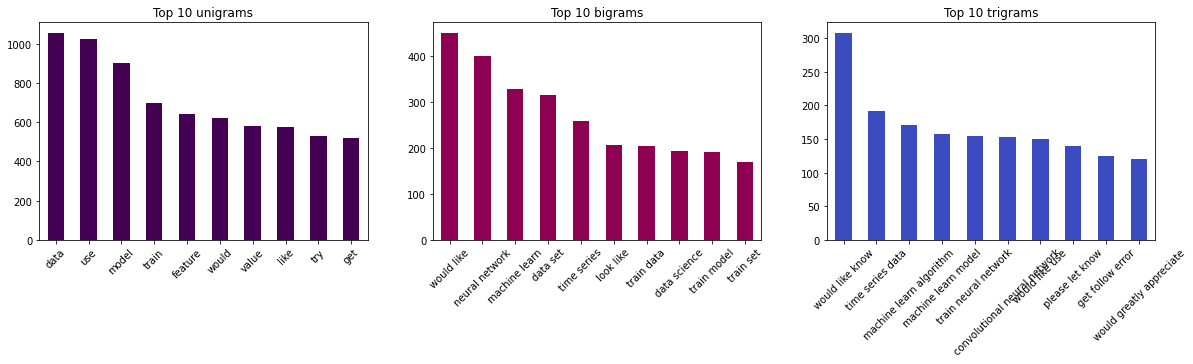

In [17]:
'''
4c. Visualizations using the optimal tfidf params 
'''
def get_top_n_tfidf_words(corpus, n, ngram):
    tfidf_vect = TfidfVectorizer(min_df=.001,max_df=.999, ngram_range=(ngram,ngram)).fit(corpus)
    tfidf_words = tfidf_vect.transform(corpus)
    sum_words = tfidf_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf_vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Accepts series, top n key words, n_gram
tfidf_unigrams = get_top_n_tfidf_words(questions_df_clean['BodyText_Clean'], 10, 1)
tfidf_bigrams = get_top_n_tfidf_words(questions_df_clean['BodyText_Clean'], 10, 2)
tfidf_trigrams = get_top_n_tfidf_words(questions_df_clean['BodyText_Clean'], 10, 3)

def unpack(tuples):
    x_tfidf_labels = [val[0] for val in tuples]
    y_tfidf_labels = [val[1] for val in tuples]
    return x_tfidf_labels, y_tfidf_labels

# Adjust size
plt.figure(figsize=(20,4))

# Unigrams
ax_one = plt.subplot(1,3,1)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis', ax=ax_one) # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
ax.tick_params(axis='x', labelrotation = 45)
ax_one.set_title('Top 10 unigrams');

# Bigrams
ax_two = plt.subplot(1,3,2)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG', ax=ax_two)
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)
ax_two.set_title('Top 10 bigrams');

# Trigrams
ax_three = plt.subplot(1,3,3)
x_tfidf_labels, y_tfidf_labels= unpack(tfidf_trigrams)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm', ax=ax_three)
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)
ax_three.set_title('Top 10 trigrams');

In [18]:
'''
4c. Continued - Revise the visualizations from above using the optimal tfidf params re-iterate on this step with 
dataframe filtered down to certain top 6 tags (machine-learning, python, neural-network, 
deep-learning, classification, and r - also visualization, since I noted
unique words associated with that topic)
'''
ML_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'machine-learning']
python_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'python']
NN_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'neural-network']
DL_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'deep-learning']
class_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'classification']  
r_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'r'] 
viz_df = questions_df_clean.loc[questions_df_clean['Tag'] == 'visualization']                                 

# Accepts series, top n key words, n_gram
tfidf_unigrams_ML = get_top_n_tfidf_words(ML_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_ML = get_top_n_tfidf_words(ML_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_ML = get_top_n_tfidf_words(ML_df['BodyText_Clean'], 10, 3)

tfidf_unigrams_python = get_top_n_tfidf_words(python_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_python = get_top_n_tfidf_words(python_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_python = get_top_n_tfidf_words(python_df['BodyText_Clean'], 10, 3)

tfidf_unigrams_NN = get_top_n_tfidf_words(NN_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_NN = get_top_n_tfidf_words(NN_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_NN = get_top_n_tfidf_words(NN_df['BodyText_Clean'], 10, 3)

tfidf_unigrams_DL = get_top_n_tfidf_words(DL_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_DL = get_top_n_tfidf_words(DL_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_DL = get_top_n_tfidf_words(DL_df['BodyText_Clean'], 10, 3)

tfidf_unigrams_class = get_top_n_tfidf_words(class_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_class = get_top_n_tfidf_words(class_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_class = get_top_n_tfidf_words(class_df['BodyText_Clean'], 5, 3)

tfidf_unigrams_r = get_top_n_tfidf_words(r_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_r = get_top_n_tfidf_words(r_df['BodyText_Clean'], 10, 2)
tfidf_trigrams_r = get_top_n_tfidf_words(r_df['BodyText_Clean'], 5, 3)

tfidf_unigrams_viz = get_top_n_tfidf_words(viz_df['BodyText_Clean'], 10, 1)
tfidf_bigrams_viz = get_top_n_tfidf_words(viz_df['BodyText_Clean'], 10, 2)
#tfidf_trigrams_viz = get_top_n_tfidf_words(viz_df['BodyText_Clean'], 1, 3)

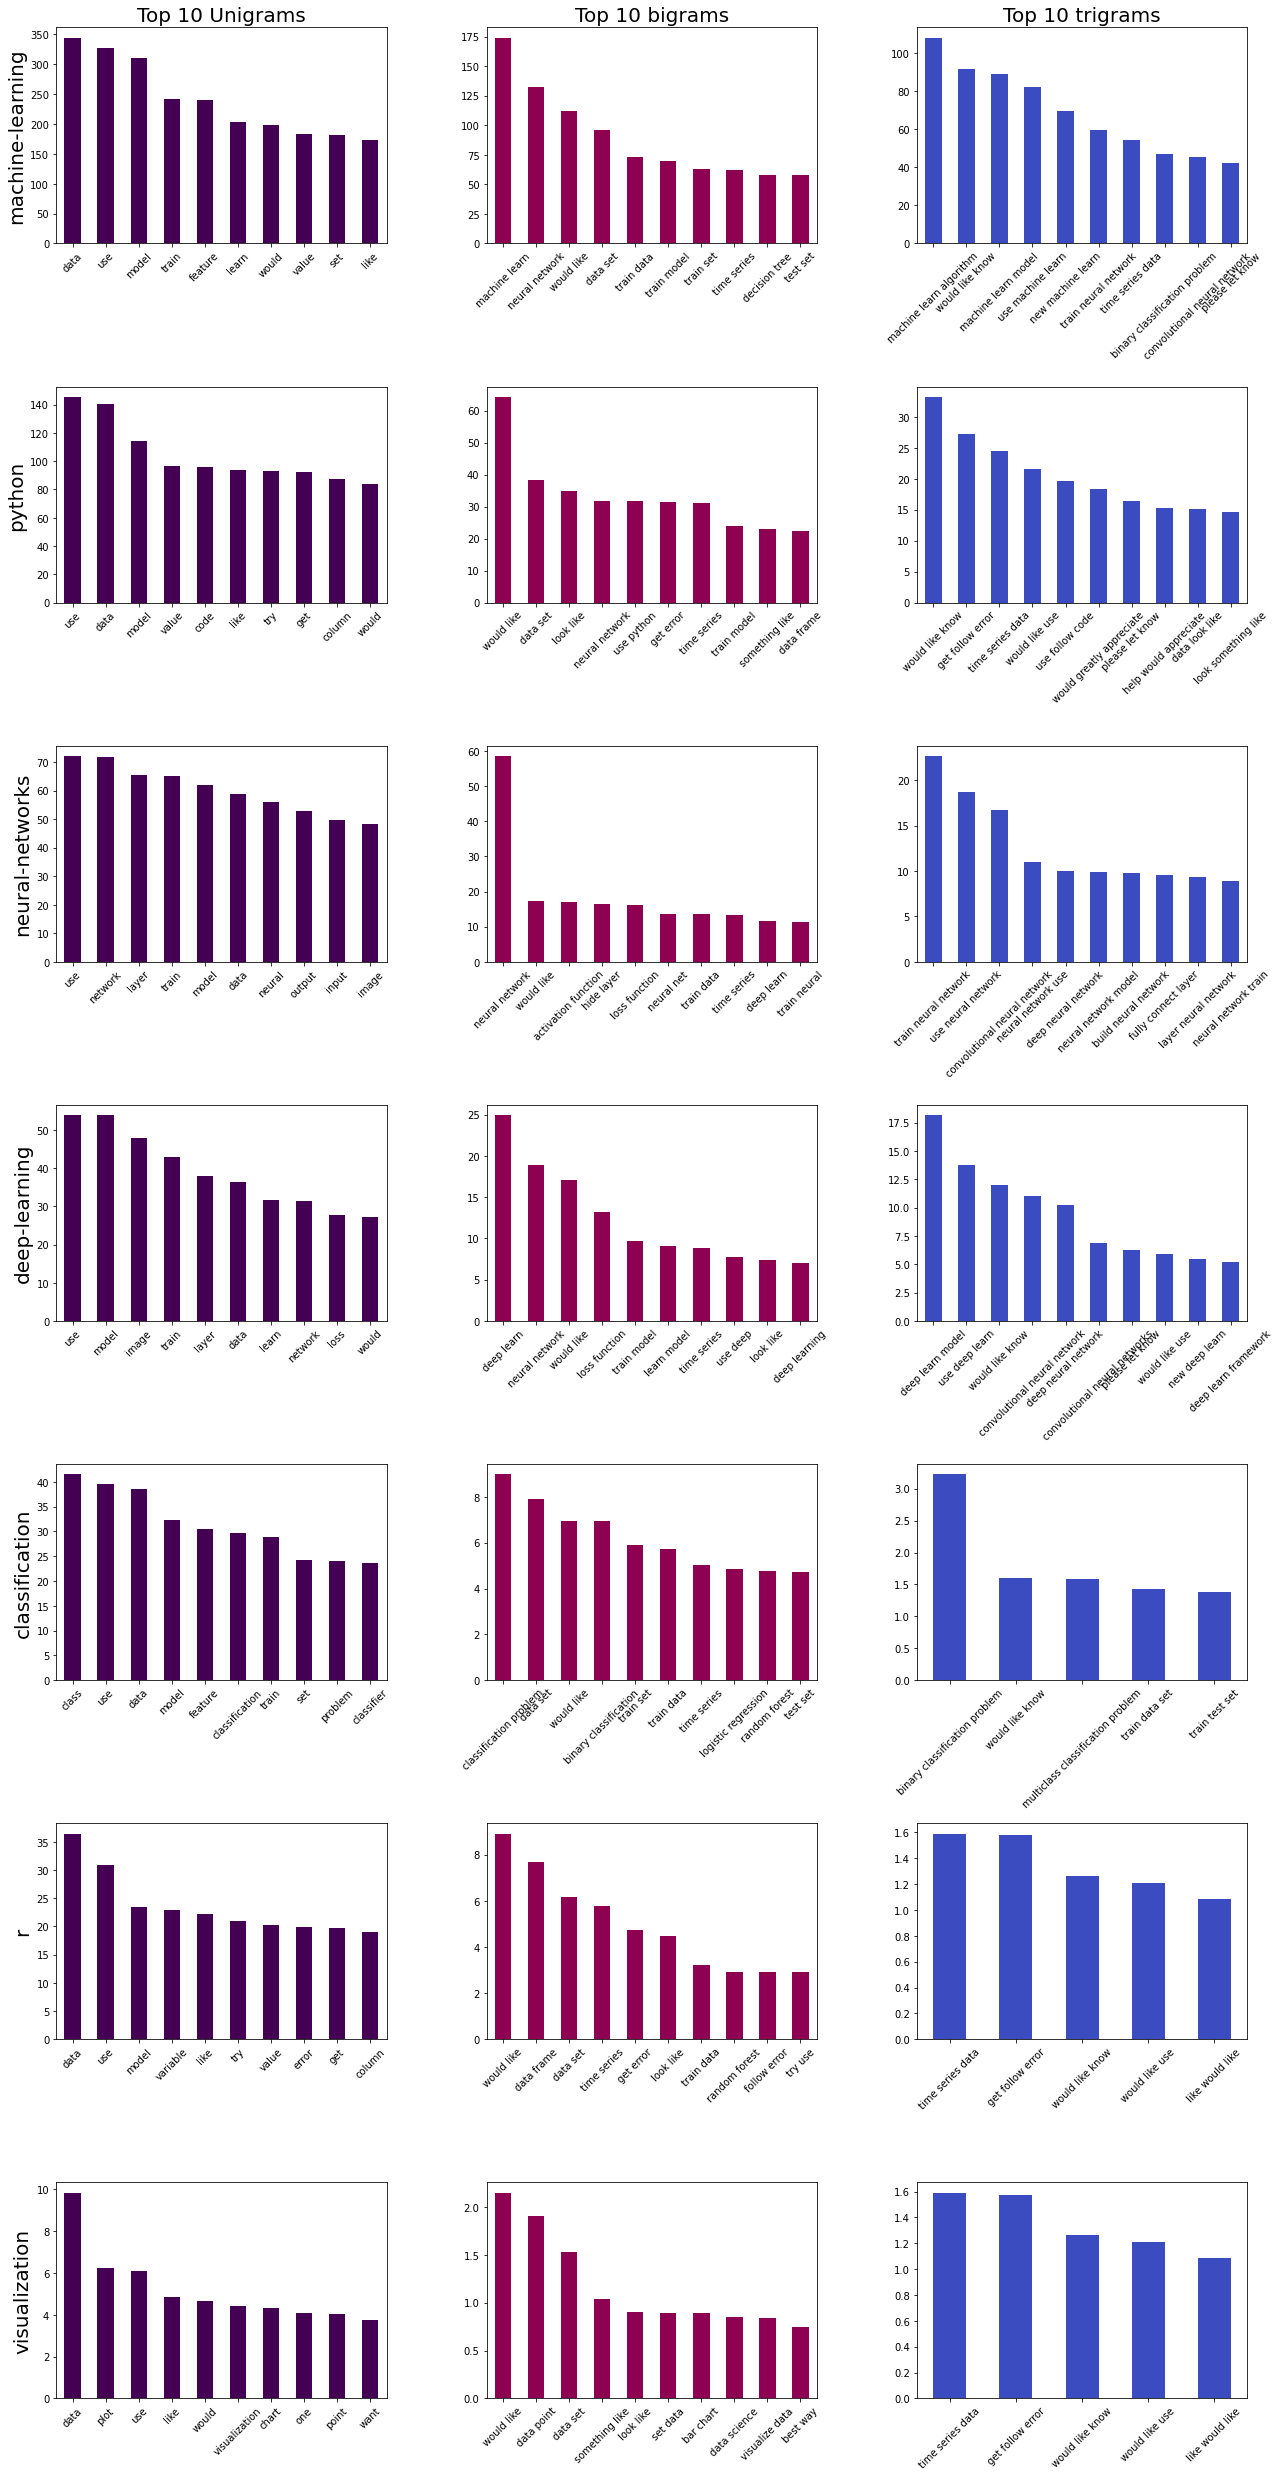

In [19]:
'''
4c.Print results as subplots
'''
# Adjust size

#fig, axs = plt.subplots(4, 3)
plt.figure(figsize=(20,36))
plt.tight_layout(pad = 10)

# Unigrams
plt.subplot(7,3,1)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_ML) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
ax.set_title('Top 10 Unigrams', fontsize=20)
plt.ylabel('machine-learning', fontsize=20)
plt.tight_layout(pad = 10)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,4)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_python) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('python', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,7)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_NN) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('neural-networks', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,10)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_DL) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('deep-learning', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,13)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_class) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('classification', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,16)
x_tfidf_labels, y_tfidf_labels= unpack(tfidf_unigrams_r) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('r', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,19)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_unigrams_viz) # Get labels - x = words, y = word count
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='viridis') # Plot bar graph
ax.set_xticklabels(x_tfidf_labels) # Add x labels
plt.ylabel('visualization', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

# Bigrams
plt.subplot(7,3,2)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_ML)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.set_title('Top 10 bigrams', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,5)
x_tfidf_labels, y_tfidf_labels= unpack(tfidf_bigrams_python)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,8)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_NN)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,11)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_DL)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,14)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_class)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,17)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_r)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,20)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_bigrams_viz)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='PiYG')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

# Trigrams
plt.subplot(7,3,3)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_ML)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.set_title('Top 10 trigrams', fontsize=20)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,6)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_python)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,9)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_NN)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,12)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_DL)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,15)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_class)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,18)
x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_r)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

plt.subplot(7,3,21)
#x_tfidf_labels, y_tfidf_labels = unpack(tfidf_trigrams_viz)
ax = pd.Series(y_tfidf_labels).plot(kind='bar', cmap='coolwarm')
ax.set_xticklabels(x_tfidf_labels)
ax.tick_params(axis='x', labelrotation = 45)

# Task 5 - Using 3 different transformations to convert the text data into numerical vector format;Doc2Vec - 3rd type of transformation
5a. Prep data - requires creation of Tagged Docs for dev and cv datasets 5b Build a default doc2vec model 5c. Performing hyperparameter tuning 5d. Run optimized Doc2Vec model and evaluate 5e. Visualization using PCA?

In [21]:
'''
5a. Prepare text - convert to TaggedDocument - but need to transform train, validate, and test separately
'''
# Build separate dataframes with the dev, cv, and test splits
y_dev_rf = np.vectorize(reversefactor.get)(y_dev)
y_cv_rf = np.vectorize(reversefactor.get)(y_cv)
y_test_rf = np.vectorize(reversefactor.get)(y_test)

d2v_dev_df = pd.DataFrame({'y': y_dev_rf, 'X': X_dev.BodyText_Clean})
d2v_cv_df = pd.DataFrame({'y': y_cv_rf, 'X': X_cv.BodyText_Clean})
d2v_test_df = pd.DataFrame({'y': y_test_rf, 'X': X_test.BodyText_Clean})
#d2v_dev_df.head()

# Ensure they're all string datatype
d2v_dev_df['X'] = d2v_dev_df['X'].astype(str)
d2v_cv_df['X'] = d2v_cv_df['X'].astype(str)
d2v_test_df['X'] = d2v_test_df['X'].astype(str)
d2v_dev_df.head()

class TaggedDocumentIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(words=doc.split(), tags=[self.labels_list[idx]])
 
docLabels_dev = list(d2v_dev_df['y'])
data_dev = list(d2v_dev_df['X'])
tagged_docs_dev = TaggedDocumentIterator(data_dev, docLabels_dev)

docLabels_cv = list(d2v_cv_df['y'])
data_cv = list(d2v_cv_df['X'])
tagged_docs_cv = TaggedDocumentIterator(data_cv, docLabels_cv)

docLabels_test = list(d2v_test_df['y'])
data_test = list(d2v_test_df['X'])
tagged_docs_test = TaggedDocumentIterator(data_test, docLabels_test)

type(tagged_docs_dev)
d2v_dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11921 entries, 8286 to 3207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       11921 non-null  object
 1   X       11921 non-null  object
dtypes: object(2)
memory usage: 279.4+ KB


In [22]:
#y_dev_rf.isnull().count()
#d2v_dev_df['y'].isnull().count()
d2v_dev_df.head(10)

,y,X
8286,Other,seems like thing httpswwwsciencedirectcomscien...
23415,keras,build 2hidden layer mlp use keras use scikit l...
23360,keras,write fast rcnn run problem back propagation g...
1698,machine-learning,hear multilayer perceptron approximate functio...
24085,Other,try correlation analysis dataset data cleanse ...
21088,deep-learning,try design reinforcement learn algorithm actio...
1958,machine-learning,get start machine learn deal linear regression...
20322,python,tensorflow tutorial experiment time series lst...
18160,Other,manually stop local background job run loop ma...
16834,Other,try create library sparse train would need fas...


In [23]:
taggeddoclist_dev = list(tagged_docs_dev)
print(taggeddoclist_dev[1])

TaggedDocument(['build', '2hidden', 'layer', 'mlp', 'use', 'keras', 'use', 'scikit', 'learn', 'wrapper', 'able', 'use', 'functionality', 'samplesize', 'limit', 'force', 'use', 'kfold', 'verification', 'well', 'trustworthy', 'result', 'however', 'understand', 'every', 'iteration', 'kfold', 'validation', 'input', 'data', 'scale', 'output', 'descale', 'use', 'train', 'data', 'require', 'scale', 'perform', 'inside', 'keras', 'model', 'order', 'understandable', 'result', 'output', 'transform', 'back', 'use', 'previously', 'find', 'scale', 'parameter', 'order', 'calculate', 'metric', 'possible', 'zscore', 'standardize', 'input', 'data', 'x', 'normalization', 'layer', 'batchnormalization', 'example', 'transform', 'output', 'layer', 'back', 'calculate', 'metric', 'use', 'scale', 'parameter', 'find', 'look', 'batchnormalization', 'functionality', 'keras', 'documentation', 'mention', 'train', 'time', 'batchnormalizationinverse', 'batchnormalizationforward', 'guarantee', 'inverse', 'inversey', 'u

In [ ]:
'''
5b. Build a Simple Model
'''
max_epochs = 100
vec_size = 20
alpha = 0.025

docvec_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

In [ ]:
'''
5c. Build Vocabulary
'''
docvec_model.build_vocab(tagged_docs_dev)

In [ ]:
'''
5d. Train and save model
'''
docvec_model.train(tagged_docs_dev, total_examples=docvec_model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)

docvec_model.save("/content/drive/My Drive/Capstone2/Data/d2v.model")
print("Model Saved")

Model Saved


In [ ]:
'''
5e. Load model
'''
d2v_model = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/d2v.model")


In [ ]:
'''
5f. Evaluate model
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)
#d2v_model.docvecs.similiarity(tag,doc)
'''
# to find most similar doc using tags
similar_doc = d2v_model.docvecs.most_similar(4)
print(similar_doc)

# printing the vector of document at index 1 in training data (or using tag name)
print(d2v_model.docvecs[4])

[('scikit-learn', 0.8217501640319824), ('machine-learning', 0.6512241363525391), ('pandas', 0.65102219581604), ('clustering', 0.5139957070350647), ('random-forest', 0.4901578426361084), ('tensorflow', 0.43295973539352417), ('keras', 0.41973215341567993), ('lstm', 0.403967946767807), ('apache-spark', 0.40339532494544983), ('classification', 0.40136462450027466)]
[ 3.0105033  -0.6436458  -1.2692201   3.3031182   1.1507684   0.541594
 -2.255286    1.9312109  -3.8474178   0.08512759  4.009103   -0.03604512
  1.6563897   4.297701    1.324888    1.7707899  -0.3661009   1.1630663
  2.3317795   3.5786812 ]


In [ ]:
'''
5f. Evaluate model, continued
First get vectors and tags for dev and cv sets 
and train the model from the dev set
Then run base random forest multi-class model to evaluate the success of doc2vec transform on cv set
then calculate the scores
'''
dev_targets, dev_regressors = zip(*[(doc.tags[0], d2v_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
cv_targets, cv_regressors = zip(*[(doc.tags[0], d2v_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])
print(cv_targets[4])
print(cv_regressors[4])

data-mining
[ 0.43418112  0.02607402  0.09349388 -0.11974251  0.08001885  0.23742315
 -0.19714901 -0.03687312 -0.2234109  -0.13100247  0.27528068 -0.06761309
  0.01372891  0.2626247   0.14812538  0.08854276  0.07361237  0.1437546
  0.4054027   0.12232441]


In [ ]:
'''
5f. Evaluate model, continued
Then run base random forest multi-class model to evaluate the success of doc2vec transform on cv set
then calculate the scores
'''
rf_base_d2v  = RandomForestClassifier(n_estimators=10, max_features='sqrt', criterion = 'entropy', random_state = 42)
rf_base_d2v.fit(dev_regressors, dev_targets)
cv_targets_pred_d2v = rf_base_d2v.predict(cv_regressors)

In [ ]:
'''
5f. Print scores
'''
print("Train Score:        ", round(rf_base_d2v.score(dev_regressors,dev_targets),4))

cv_targets_prob_d2v = rf_base_d2v.predict_proba(cv_regressors)
macro_roc_auc_ovo_d2v = roc_auc_score(cv_targets, cv_targets_prob_d2v, multi_class="ovo",
                                  average="macro")
print("Cross Val AUC Score:", round(macro_roc_auc_ovo_d2v,4))


Train Score:         0.9915
Cross Val AUC Score: 0.5683
Pred Accuracy Score: 0.2352
                        precision    recall  f1-score   support

                 Other       0.14      0.24      0.18       591
          apache-spark       0.14      0.05      0.08        19
               bigdata       0.14      0.03      0.04        39
        classification       0.08      0.06      0.07       192
            clustering       0.17      0.11      0.14        79
                   cnn       0.00      0.00      0.00        36
                  data       0.00      0.00      0.00        29
           data-mining       0.09      0.07      0.08        84
               dataset       0.00      0.00      0.00        80
        decision-trees       0.00      0.00      0.00        21
         deep-learning       0.08      0.07      0.08       236
     feature-selection       0.00      0.00      0.00        38
                 keras       0.10      0.05      0.07       119
     linear-regress

In [ ]:
'''
5g. Hyperparameter tuning of Doc2Vec Vector size; 
will do this the manual way for now Starting with 50 vector model
'''
# Run 50 vector Model and Save

docvec_model50 = Doc2Vec(vector_size=50,alpha=0.025, min_alpha=0.00025,min_count=1,dm =1)
docvec_model50.build_vocab(tagged_docs_dev)
docvec_model50.train(tagged_docs_dev, total_examples=docvec_model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)
docvec_model50.save("/content/drive/My Drive/Capstone2/Data/d2v50.model")
print("Model Saved")

Model Saved


In [ ]:
'''
5g. Hyperparameter tuning of Doc2Vec Vector size; 
100 Vector Model
'''
# Run 100 vector Model and Save

docvec_model100 = Doc2Vec(vector_size=100,alpha=0.025, min_alpha=0.00025,min_count=1,dm =1)
docvec_model100.build_vocab(tagged_docs_dev)
docvec_model100.train(tagged_docs_dev, total_examples=docvec_model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)
docvec_model100.save("/content/drive/My Drive/Capstone2/Data/d2v100.model")
print("Model Saved")

Model Saved


In [ ]:
'''
5g. Hyperparameter tuning of Doc2Vec Vector size; 
150 Vector Model
'''
# Run 150 vector Model and Save

docvec_model150 = Doc2Vec(vector_size=150,alpha=0.025, min_alpha=0.00025,min_count=1,dm =1)
docvec_model150.build_vocab(tagged_docs_dev)
docvec_model150.train(tagged_docs_dev, total_examples=docvec_model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)
docvec_model150.save("/content/drive/My Drive/Capstone2/Data/d2v150.model")
print("Model Saved")

Model Saved


In [ ]:
'''
5g. Hyperparameter tuning of Doc2Vec Vector size; 
200 Vector Model
'''
# Run 200 vector Model and Save

docvec_model200 = Doc2Vec(vector_size=200,alpha=0.025, min_alpha=0.00025,min_count=1,dm =1)
docvec_model200.build_vocab(tagged_docs_dev)
docvec_model200.train(tagged_docs_dev, total_examples=docvec_model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)
docvec_model200.save("/content/drive/My Drive/Capstone2/Data/d2v200.model")
print("Model Saved")

Model Saved


In [ ]:
'''
5g. Hyperparameter tuning of Doc2Vec Vector size; 
using dev and cv sets only; vec size 50, 100, 150, 200
'''
# Load Each Model and Evaluate with Random Forest Base Model

d2v_model_50 = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/d2v50.model")
dev_targets_50, dev_regressors_50 = zip(*[(doc.tags[0], d2v_model_50.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
cv_targets_50, cv_regressors_50 = zip(*[(doc.tags[0], d2v_model_50.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])
rf_base_d2v_50  = RandomForestClassifier(n_estimators=10, max_features='sqrt', criterion = 'entropy', random_state = 42)
fitted_50 = rf_base_d2v_50.fit(dev_regressors_50, dev_targets_50)
cv_targets_pred_50 = rf_base_d2v_50.predict(cv_regressors_50)

# Load 100 Vector Model and Evaluate with Random Forest Base Model

d2v_model_100 = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/d2v100.model")
dev_targets_100, dev_regressors_100 = zip(*[(doc.tags[0], d2v_model_100.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
cv_targets_100, cv_regressors_100 = zip(*[(doc.tags[0], d2v_model_100.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])
rf_base_d2v_100  = RandomForestClassifier(n_estimators=10, max_features='sqrt', criterion = 'entropy', random_state = 42)
fitted_100 = rf_base_d2v_100.fit(dev_regressors_100, dev_targets_100)
cv_targets_pred_100 = rf_base_d2v_100.predict(cv_regressors_100)

# Load 150 Vector Model and Evaluate with Random Forest Base Model

d2v_model_150 = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/d2v150.model")
dev_targets_150, dev_regressors_150 = zip(*[(doc.tags[0], d2v_model_150.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
cv_targets_150, cv_regressors_150 = zip(*[(doc.tags[0], d2v_model_150.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])
rf_base_d2v_150  = RandomForestClassifier(n_estimators=10, max_features='sqrt', criterion = 'entropy', random_state = 42)
fitted_150 = rf_base_d2v_150.fit(dev_regressors_150, dev_targets_150)
cv_targets_pred_150 = rf_base_d2v_150.predict(cv_regressors_150)

# Load 200 Vector Model and Evaluate with Random Forest Base Model

d2v_model_200 = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/d2v200.model")
dev_targets_200, dev_regressors_200 = zip(*[(doc.tags[0], d2v_model_200.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
cv_targets_200, cv_regressors_200 = zip(*[(doc.tags[0], d2v_model_200.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])
rf_base_d2v_200  = RandomForestClassifier(n_estimators=10, max_features='sqrt', criterion = 'entropy', random_state = 42)
fitted_200 = rf_base_d2v_200.fit(dev_regressors_200, dev_targets_200)
cv_targets_pred_200 = rf_base_d2v_200.predict(cv_regressors_200)

In [ ]:
'''
5g. Print scores - Interestingly enough, it seems like using smaller vector sizes works to improve 
the prediction accuracy. Will try using a different range - perhaps 10, 20, 30, 40, 50?
'''
print("Train Score  50 Vectors: ", round(rf_base_d2v_50.score(dev_regressors_50,dev_targets_50),4))
print("Train Score 100 Vectors: ", round(rf_base_d2v_100.score(dev_regressors_100,dev_targets_100),4))
print("Train Score 150 Vectors: ", round(rf_base_d2v_150.score(dev_regressors_150,dev_targets_150),4))
print("Train Score 200 Vectors: ", round(rf_base_d2v_200.score(dev_regressors_200,dev_targets_200),4))

cv_targets_prob50 = rf_base_d2v_50.predict_proba(cv_regressors_50)
cv_targets_prob100 = rf_base_d2v_100.predict_proba(cv_regressors_100)
cv_targets_prob150 = rf_base_d2v_150.predict_proba(cv_regressors_150)
cv_targets_prob200 = rf_base_d2v_200.predict_proba(cv_regressors_200)

macro_roc_auc_ovo50 = roc_auc_score(cv_targets, cv_targets_prob50, multi_class="ovo", average="macro")
macro_roc_auc_ovo100 = roc_auc_score(cv_targets, cv_targets_prob100, multi_class="ovo", average="macro")
macro_roc_auc_ovo150 = roc_auc_score(cv_targets, cv_targets_prob150, multi_class="ovo", average="macro")
macro_roc_auc_ovo200 = roc_auc_score(cv_targets, cv_targets_prob200, multi_class="ovo", average="macro")

print("Cross Val AUC Score 50 : ", round(macro_roc_auc_ovo50,4))
print("Cross Val AUC Score 100: ", round(macro_roc_auc_ovo100,4))
print("Cross Val AUC Score 150: ", round(macro_roc_auc_ovo150,4))
print("Cross Val AUC Score 200: ", round(macro_roc_auc_ovo200,4))

Train Score  50 Vectors:  0.9924
Train Score 100 Vectors:  0.9908
Train Score 150 Vectors:  0.9908
Train Score 200 Vectors:  0.9903
Cross Val AUC Score 50 :  0.5485
Cross Val AUC Score 100:  0.522
Cross Val AUC Score 150:  0.5253
Cross Val AUC Score 200:  0.5109


In [ ]:
'''
5g. Hyperparameter tuning of other Doc2Vec params using looping method
dm = [0,1] - type of training algorithm - dm vs DBOW
vector size = [25, 50, 100, 200, 500]
window = [1, 2, 3, 4, 5] - the maximum distance between the current and predicted word within a sentence
hs = [1,0] - hierarchical softmax will be used for model training; if set to 0, and negative is non-zero, negative sampling will be used
epochs = [10,25,50,100]
'''
dm = [0,1]
vector_size = [25, 50, 100, 200, 500]
window = [1, 2, 3, 4, 5]
hs = [1,0]
epochs = [10,25,50,100]
paramsList = [{'dm': item[0],
               'vector_size': item[1],
               'window': item[2],
               'hs': item[3],
               'epoch': item[4]
               } for item in
                 list(itertools.product(*[dm,
                                          vector_size,
                                          window,
                                          hs, epochs]))
              ]

In [ ]:
'''
5g. Loop to run hyperparams and score the results - warning this takes over 2 hrs to run with 10 epochs and lists above
'''
scoreList = []
for param in paramsList:
  param['AUC'] = 0
  model = None
  try:
    docvec_model = Doc2Vec(tagged_docs_dev,
                      dm=param['dm'], 
                      vector_size=param['vector_size'], 
                      window=param['window'], 
                      min_count=1, 
                      epochs=param['epoch'], 
                      hs=param['hs'])
    dev_targets, dev_regressors = zip(*[(doc.tags[0], docvec_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
    cv_targets, cv_regressors = zip(*[(doc.tags[0], docvec_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv]) 
    rf_base_temp  = RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy', random_state = 42)
    fit_temp = rf_base_temp.fit(dev_regressors, dev_targets)
    cv_targets_pred_temp = rf_base_temp.predict(cv_regressors)
    cv_targets_prob_temp = rf_base_temp.predict_proba(cv_regressors)
    param['AUC'] = roc_auc_score(cv_targets, cv_targets_prob_temp, multi_class="ovo", average="macro")
    scoreList.append(param)
    score_doc2vec = pd.DataFrame(scoreList)
  except Exception as error:
    print(f'Cannot evaluate model with parameters {param} because of error: {error}')
    continue
  gc.collect() # Memory optimization to clear buffers
  if score_doc2vec.shape[0]%5 == 0:
    score_doc2vec.to_excel("/content/drive/My Drive/Capstone2/Data/doc2vec_tuning100_041921.xlsx")

score_doc2vec.to_excel("/content/drive/My Drive/Capstone2/Data/doc2vec_tuning100_041921.xlsx")


In [24]:
'''
5h. Running final optimized doc2vec transformation
Hyperparam results dm = 0, vector_size = 50, hs = 0, window = 4 epochs = 10 are the optimal params
Hyperparam results dm = 0, vector_size = 100, hs = 0, window = 1 epochs = 10 are the optimal params
Hyperparam results dm = 0, vector_size = 200, hs = 0, window = 5 epochs = 10 are the optimal params
Hyperparam results dm = 0, vector_size = 500, hs = 0, window = 4 epochs = 10 are the optimal params
'''
# Build Model
fin_docvec_model_200 = Doc2Vec(vector_size=200,
                alpha=0.025, 
                min_alpha=0.00025,
                min_count=1,
                epochs=10, 
                dm =0, window=4, hs=0)

# Build Vocabulary
fin_docvec_model_200.build_vocab(tagged_docs_dev)

#Train and save model

fin_docvec_model_200.train(tagged_docs_dev, total_examples=fin_docvec_model_200.corpus_count, epochs=10, start_alpha=0.01, end_alpha=0.01)

fin_docvec_model_200.save("/content/drive/My Drive/Capstone2/Data/final_d2v_200.model")
print("Model Saved")

Model Saved


In [25]:
# 5h. Load model

#fin_docvec_model_200 = Doc2Vec.load("/content/drive/My Drive/Capstone2/Data/final_d2v_200.model")

#Evaluate model, continued
#First get vectors and tags for dev and cv sets 

fnl_dev_targets, fnl_dev_regressors = zip(*[(doc.tags[0], fin_docvec_model_200.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
fnl_cv_targets, fnl_cv_regressors = zip(*[(doc.tags[0], fin_docvec_model_200.infer_vector(doc.words, steps=20)) for doc in tagged_docs_cv])

# Run base random forest multi-class model to evaluate the success of doc2vec transform on cv set

fnl_rf_base_d2v  = RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy', random_state = 42)
fnl_fit = fnl_rf_base_d2v.fit(fnl_dev_regressors, fnl_dev_targets)
fnl_cv_targets_pred_d2v = fnl_rf_base_d2v.predict(fnl_cv_regressors)

#Print scores

print("Train Score:        ", round(fnl_rf_base_d2v.score(fnl_dev_regressors,fnl_dev_targets),4))

fnl_cv_targets_prob_d2v = fnl_rf_base_d2v.predict_proba(fnl_cv_regressors)
#print(fnl_cv_targets_prob_d2v)
macro_roc_auc_ovo_d2v = roc_auc_score(fnl_cv_targets, fnl_cv_targets_prob_d2v, multi_class="ovo", average="macro")

print("Cross Val AUC Score:", round(macro_roc_auc_ovo_d2v,4))


Train Score:         1.0
Cross Val AUC Score: 0.8531


In [26]:
'''
Perform PCA analysis of results of doc2vec and graph
5i. Perform PCA analysis of results of doc2vec and graph

pca.explained_variance_ratio_

PCA:
We will be implementing PCA using the numpy library. Steps involved in PCA are as follows-
1-Standardize the dataset and compute the correlation matrix.
2-Calculate the eigenvalues and eigenvectors using eigen decomposition.
3-Sort the eigenvalues and their coresponding eigen vectors.
4-Pick top two eigenvalues an create a matrix of eigen vectors.
5-Transform the original data using dot product with these new eigen vectors.
In this case, we can ignore the standardization step, since the data is in same unit.
#Computing the correlation matrix
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)

import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(model.wv.vocab)
for i, word in enumerate(vocab):
  plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

3D plot
import plotly.express as px
from sklearn.decomposition import PCA

df = px.data.iris()
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()
'''

# Standardizing the Data (normalizing the scale)
scaler = StandardScaler()
#dev_targets, dev_regressors = zip(*[(doc.tags[0], d2v_model.infer_vector(doc.words, steps=20)) for doc in tagged_docs_dev])
#cv_targets, cv_regressors
d2v_std = scaler.fit_transform(fnl_dev_regressors)
d2v_std_val = scaler.fit_transform(fnl_cv_regressors)

#d2v_pca = PCA().fit(d2v_std)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(d2v_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['y'] = fnl_dev_targets
#finalPCA_df = pd.concat([principalDf, d2v_dev_df['y']], axis = 1)
principalDf.head(10)

,principal component 1,principal component 2,y
0,-15.953572,3.098099,Other
1,6.843273,8.991193,keras
2,1.597624,9.181874,keras
3,1.173483,3.755937,machine-learning
4,-3.907643,-6.324759,Other
5,5.937397,1.347810,deep-learning
6,3.160673,-1.408174,machine-learning
7,6.413209,7.842611,python
8,-3.685931,-2.028496,Other
9,3.393852,1.812903,Other


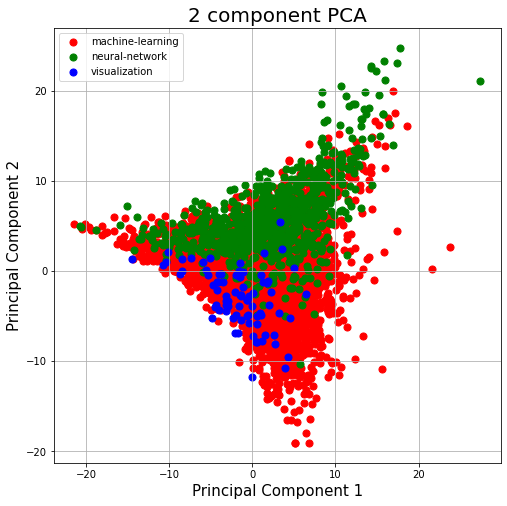

In [41]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['machine-learning', 'neural-network', 'visualization']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['y'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


In [28]:
#d2v_pca = PCA().fit(d2v_std)
pca = PCA(n_components=3)
principalComponents3 = pca.fit_transform(d2v_std)
principalDf3 = pd.DataFrame(data = principalComponents3
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf3['y'] = fnl_dev_targets
#finalPCA_df = pd.concat([principalDf, d2v_dev_df['y']], axis = 1)
#principalDf.head(10)

total_var = pca.explained_variance_ratio_.sum() * 100

#3D plot
import plotly.express as px

fig = px.scatter_3d(
    principalComponents3, x=0, y=1, z=2, color=principalDf3['y'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()